In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

**1. Feature Engineering (First Priority)**

In [ ]:

paths = {
    "AMD": "/content/amd.csv",
    "Broadcom": "/content/broadcom.csv",
    "Intel": "/content/intc.csv",
    "S&P500": "/content/sp500.csv"
}

#loading and preprocessing datasets
data = {name: pd.read_csv(path) for name, path in paths.items()}
for name, df in data.items():
    #converting 'Date' to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)

    #creating lagged features (last 3 days)
    df['Close_lag1'] = df['Close'].shift(1)
    df['Close_lag2'] = df['Close'].shift(2)
    df['Close_lag3'] = df['Close'].shift(3)

    #rolling statistics (7-day moving average and volatility)
    df['Rolling_Mean_7'] = df['Close'].rolling(window=7).mean()
    df['Rolling_Std_7'] = df['Close'].rolling(window=7).std()

    #technical indicators (20-day Moving Average, Relative Strength Index)
    df['Moving_Avg_20'] = df['Close'].rolling(window=20).mean()
    df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change(1).rolling(window=14).apply(
        lambda x: (x[x > 0].sum() / -x[x < 0].sum()) if -x[x < 0].sum() != 0 else 1, raw=True)))

    data[name] = df.dropna()

#merge datasets on Date (common index for alignment)
merged_data = data['AMD'].set_index('Date').join(
    data['Broadcom'].set_index('Date').add_suffix('_Broadcom'),
    how='inner'
).join(
    data['Intel'].set_index('Date').add_suffix('_Intel'),
    how='inner'
).join(
    data['S&P500'].set_index('Date').add_suffix('_SP500'),
    how='inner'
)

nvda_data = pd.read_csv('/content/nvda.csv')
nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])
nvda_data.sort_values(by='Date', inplace=True)

#here im aligning nvdia with merged datasets
merged_data = merged_data.join(
    nvda_data.set_index('Date')[['Close']].rename(columns={'Close': 'Close_NVIDIA'}),
    how='inner'
)

merged_data = merged_data.dropna()

print(merged_data.info())
print(merged_data.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3822 entries, 2009-09-04 to 2024-11-11
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Open                      3822 non-null   float64
 1   Close                     3822 non-null   float64
 2   Volume                    3822 non-null   float64
 3   Moving_Avg_20             3822 non-null   float64
 4   Moving_Avg_50             3822 non-null   float64
 5   Upper_Bollinger           3822 non-null   float64
 6   Lower_Bollinger           3822 non-null   float64
 7   RSI                       3822 non-null   float64
 8   Close_lag1                3822 non-null   float64
 9   Close_lag2                3822 non-null   float64
 10  Close_lag3                3822 non-null   float64
 11  Rolling_Mean_7            3822 non-null   float64
 12  Rolling_Std_7             3822 non-null   float64
 13  Open_Broadcom             3822 non-null   flo

**2. Define Baseline Models-RIDGE JA LASSO**

Performance Metrics for Each Stock:
      Stock  Ridge MAPE
0       AMD    4.784051
1  Broadcom    3.977870
2     Intel    1.385069
3    S&P500    0.770921
4    NVIDIA   19.418060


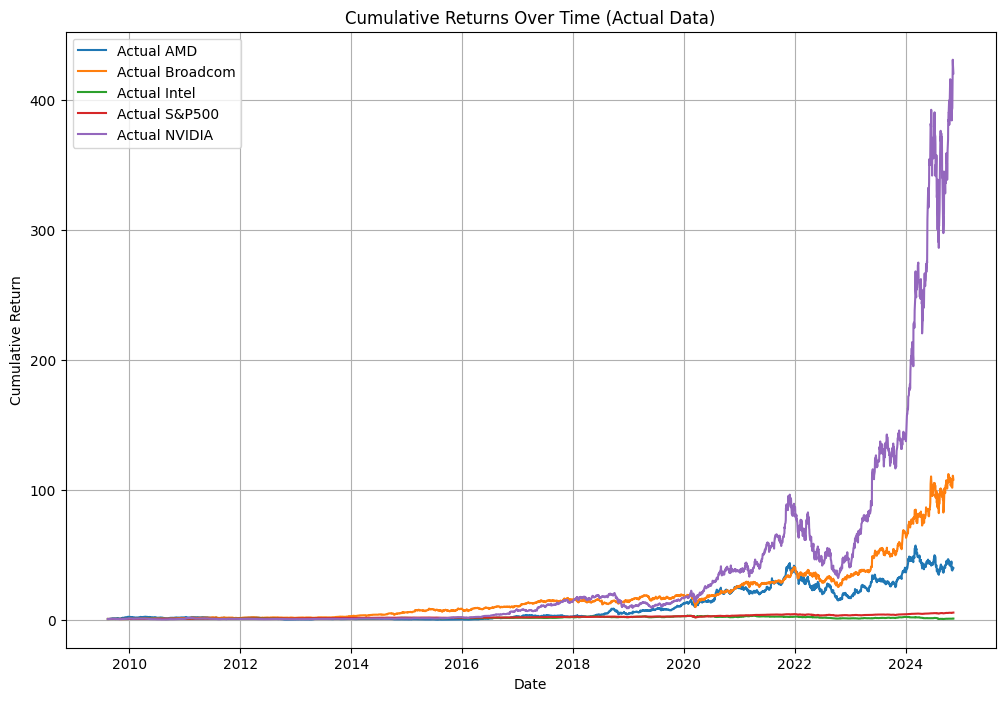

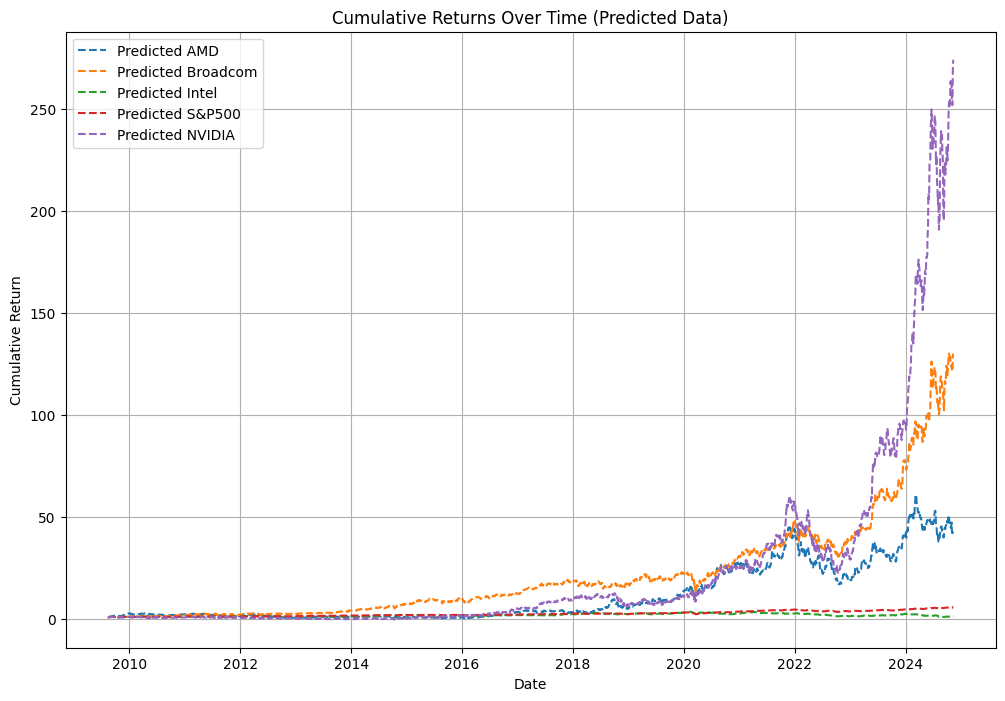

In [2]:

paths = {
    "AMD": "/content/amd.csv",
    "Broadcom": "/content/broadcom.csv",
    "Intel": "/content/intc.csv",
    "S&P500": "/content/sp500.csv",
    "NVIDIA": "/content/nvda.csv"
}
data = {name: pd.read_csv(path) for name, path in paths.items()}


for name, df in data.items():
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)
    df['Close_lag1'] = df['Close'].shift(1)
    df['Close_lag2'] = df['Close'].shift(2)
    df['Close_lag3'] = df['Close'].shift(3)
    data[name] = df.dropna()


combined = pd.DataFrame()
for name, df in data.items():
    df = df.set_index('Date')[['Close', 'Close_lag1', 'Close_lag2', 'Close_lag3']]
    df.columns = [f"{col}_{name}" for col in df.columns]
    combined = pd.concat([combined, df], axis=1)
combined.dropna(inplace=True)

predictions_full = {}
metrics = []
actual_cumulative_returns = {}
predicted_cumulative_returns = {}

for stock in paths.keys():
    target = f"Close_{stock}"
    if target not in combined.columns:
        print(f"Skipping {stock}: Target column missing.")
        continue

    features = [col for col in combined.columns if col != target]
    X = combined[features]
    y = combined[target]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))


    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_scaled, y_scaled)


    ridge_full_pred_scaled = ridge_model.predict(X_scaled)

    y_pred = scaler_y.inverse_transform(ridge_full_pred_scaled)
    y_actual = y.values


    predictions_full[stock] = {
        "Ridge": y_pred.flatten(),
        "Actual": y_actual,
        "Dates": combined.index
    }


    daily_returns_actual = pd.Series(y_actual).pct_change().fillna(0)
    cumulative_returns_actual = (1 + daily_returns_actual).cumprod()

    daily_returns_pred = pd.Series(y_pred.flatten()).pct_change().fillna(0)
    cumulative_returns_pred = (1 + daily_returns_pred).cumprod()

    actual_cumulative_returns[stock] = cumulative_returns_actual
    predicted_cumulative_returns[stock] = cumulative_returns_pred

    ridge_mape = mean_absolute_percentage_error(y_actual, y_pred.flatten()) * 100
    metrics.append({"Stock": stock, "Ridge MAPE": ridge_mape})

metrics_df = pd.DataFrame(metrics)
print("Performance Metrics for Each Stock:")
print(metrics_df)


plt.figure(figsize=(12, 8))
for stock, returns in actual_cumulative_returns.items():
    plt.plot(predictions_full[stock]['Dates'], returns, label=f"Actual {stock}")
plt.title("Cumulative Returns Over Time (Actual Data)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
for stock, returns in predicted_cumulative_returns.items():
    plt.plot(predictions_full[stock]['Dates'], returns, linestyle="--", label=f"Predicted {stock}")
plt.title("Cumulative Returns Over Time (Predicted Data)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


**Visualizing**

In [ ]:
import pandas as pd

#ensuring Nvidia stock data is loaded properly
if 'NVIDIA' not in locals():
    data = {}
    data['NVIDIA'] = pd.read_csv("/content/nvda.csv")
    data['NVIDIA']['Date'] = pd.to_datetime(data['NVIDIA']['Date'])
    data['NVIDIA'].sort_values(by='Date', inplace=True)

earnings_data = {
    "Date": ["2020-01-15", "2020-04-15", "2020-07-15", "2020-10-15", "2021-01-15"],
    "EPS": [1.25, 1.40, 1.35, 1.50, 1.60],
    "Revenue": [3.5, 3.8, 3.7, 4.0, 4.2],
    "Surprise": [0.05, 0.10, -0.02, 0.08, 0.12],
}

earnings_df = pd.DataFrame(earnings_data)
earnings_df['Date'] = pd.to_datetime(earnings_df['Date'])

data['NVIDIA'] = pd.merge(data['NVIDIA'], earnings_df, on="Date", how="left")

data['NVIDIA'].fillna({"EPS": 0, "Revenue": 0, "Surprise": 0}, inplace=True)

data['NVIDIA']['Earnings_Flag'] = (data['NVIDIA']['EPS'] != 0).astype(int)

print("Updated Nvidia Data:")
print(data['NVIDIA'].head())


Updated Nvidia Data:
        Date      Open     Close       Volume  Moving_Avg_20  Moving_Avg_50  \
0 2000-01-04  0.095833  0.094922  300480000.0       0.096224       0.096224   
1 2000-01-05  0.092188  0.091797  188352000.0       0.094748       0.094748   
2 2000-01-06  0.091797  0.085807  120480000.0       0.092513       0.092513   
3 2000-01-07  0.085417  0.087240   71184000.0       0.091458       0.091458   
4 2000-01-10  0.087500  0.090104  239856000.0       0.091233       0.091233   

   Upper_Bollinger  Lower_Bollinger        RSI  EPS  Revenue  Surprise  \
0         0.099907         0.092541   0.000000  0.0      0.0       0.0   
1         0.100485         0.089011   0.000000  0.0      0.0       0.0   
2         0.102607         0.082419   0.000000  0.0      0.0       0.0   
3         0.101391         0.081526  10.895684  0.0      0.0       0.0   
4         0.100185         0.082280  26.829408  0.0      0.0       0.0   

   Earnings_Flag  
0              0  
1              0  
2 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3838 entries, 2009-08-13 to 2024-11-11
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close_AMD            3838 non-null   float64
 1   Close_lag1_AMD       3838 non-null   float64
 2   Close_lag2_AMD       3838 non-null   float64
 3   Close_lag3_AMD       3838 non-null   float64
 4   RSI_AMD              3838 non-null   float64
 5   Close_Broadcom       3838 non-null   float64
 6   Close_lag1_Broadcom  3838 non-null   float64
 7   Close_lag2_Broadcom  3838 non-null   float64
 8   Close_lag3_Broadcom  3838 non-null   float64
 9   RSI_Broadcom         3838 non-null   float64
 10  Close_Intel          3838 non-null   float64
 11  Close_lag1_Intel     3838 non-null   float64
 12  Close_lag2_Intel     3838 non-null   float64
 13  Close_lag3_Intel     3838 non-null   float64
 14  RSI_Intel            3838 non-null   float64
 15  Close_S&P500        

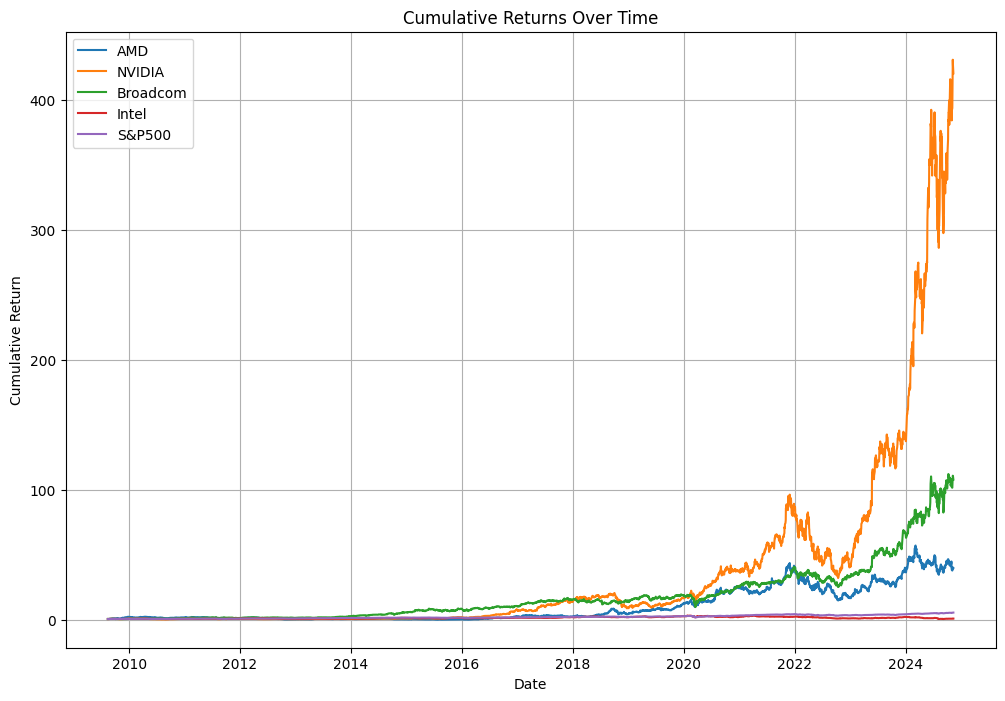

Earnings_Flag column is missing in the combined dataset!


In [ ]:
if 'Close_NVIDIA' not in combined.columns:
    nvidia_data = pd.read_csv("/content/nvda.csv")
    nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])
    nvidia_data.set_index('Date', inplace=True)

    def calculate_rsi(series, window=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    nvidia_data['RSI'] = calculate_rsi(nvidia_data['Close'])
    nvidia_data['Moving_Avg_20'] = nvidia_data['Close'].rolling(window=20).mean()
    nvidia_data['Moving_Avg_50'] = nvidia_data['Close'].rolling(window=50).mean()
    nvidia_data['Close_lag1'] = nvidia_data['Close'].shift(1)
    nvidia_data['Close_lag2'] = nvidia_data['Close'].shift(2)
    nvidia_data['Close_lag3'] = nvidia_data['Close'].shift(3)

    combined = combined.reset_index()
    combined = pd.merge(combined, nvidia_data[['Close', 'RSI', 'Moving_Avg_20', 'Moving_Avg_50',
                                               'Close_lag1', 'Close_lag2', 'Close_lag3']],
                        left_on='Date', right_index=True, how='left')
    combined.rename(columns={'Close': 'Close_NVIDIA'}, inplace=True)
    combined.set_index('Date', inplace=True)

print(combined.info())
print(combined.head())

stocks = ['Close_AMD', 'Close_NVIDIA', 'Close_Broadcom', 'Close_Intel', 'Close_S&P500']
for stock in stocks:
    combined[f'Daily_Return_{stock}'] = combined[stock].pct_change()
    combined[f'Cumulative_Return_{stock}'] = (1 + combined[f'Daily_Return_{stock}']).cumprod()

plt.figure(figsize=(12, 8))
for stock in stocks:
    plt.plot(combined.index, combined[f'Cumulative_Return_{stock}'], label=stock.replace('Close_', ''))
plt.title("Cumulative Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

if 'Earnings_Flag' in combined.columns:
    post_earnings = combined[combined['Earnings_Flag'] == 1][['EPS', 'Revenue', 'Surprise', 'Daily_Return_Close_NVIDIA']]
    print("Post-Earnings Analysis:")
    print(post_earnings)
else:
    print("Earnings_Flag column is missing in the combined dataset!")

Comparative analysis

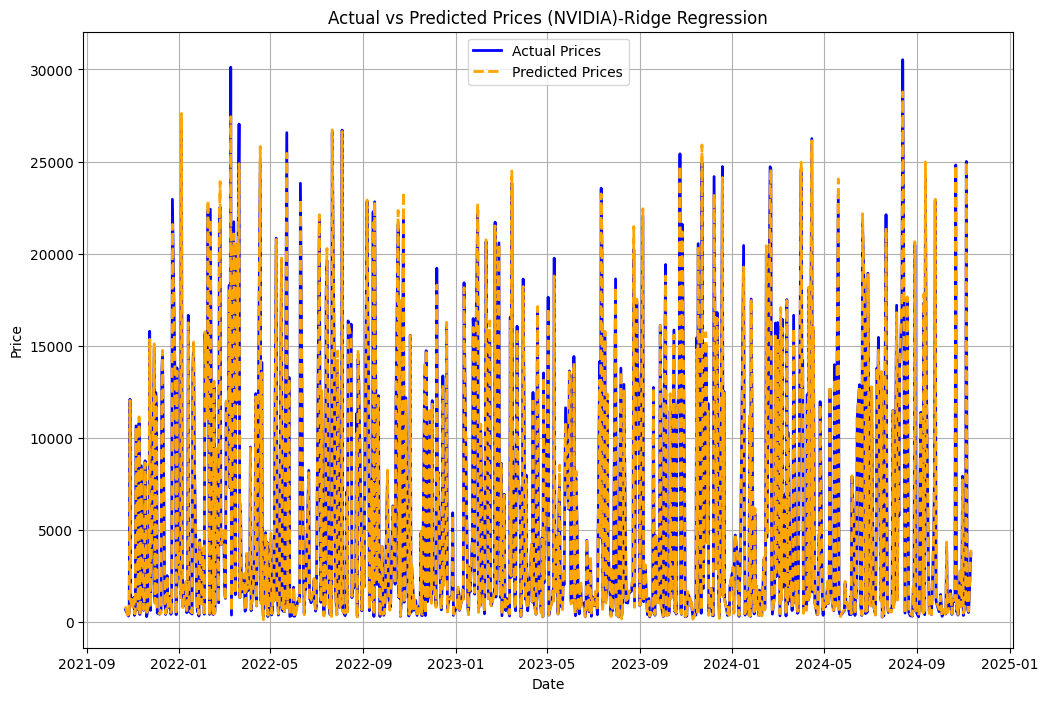

In [ ]:
predicted_prices = ridge_test_pre

min_length = min(len(y_test), len(predicted_prices))
y_test_aligned = y_test[:min_length]
predicted_prices_aligned = predicted_prices[:min_length]

y_test_original = target_scaler.inverse_transform(y_test_aligned.reshape(-1, 1)).flatten()
predicted_prices_original = target_scaler.inverse_transform(predicted_prices_aligned.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 8))
plt.plot(combined.index[-len(y_test_original):], y_test_original, label="Actual Prices", linewidth=2, color='blue')
plt.plot(combined.index[-len(y_test_original):], predicted_prices_original, label="Predicted Prices", linewidth=2, linestyle='--', color='orange')
plt.title("Actual vs Predicted Prices (NVIDIA)-Ridge Regression")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
